In [1]:
# Dependencies
import pandas as pd

In [2]:
# Merging csv files (without repeating header)
df = pd.read_csv('raw_data/Feb-2019.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15
0,2.0,1.0,5.0,JFK,LAX,8,0.0
1,2.0,2.0,6.0,JFK,LAX,8,1.0
2,2.0,3.0,7.0,JFK,LAX,8,0.0
3,2.0,4.0,1.0,JFK,LAX,8,0.0
4,2.0,5.0,2.0,JFK,LAX,8,0.0


In [3]:
df.shape

(632074, 7)

In [4]:
df.isnull().values.any()

True

In [5]:
#Number of missing values in each column
df.isnull().sum()

MONTH            98899
DAY_OF_MONTH     98899
DAY_OF_WEEK      98899
ORIGIN           98899
DEST             98899
CRS_DEP_TIME         0
DEP_DEL15       113726
dtype: int64

In [6]:
#Filtering/Showing NaN values
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15
369,2.0,17.0,7.0,MSP,ORD,17,NaN
377,2.0,17.0,7.0,ORD,MSP,15,NaN
696,2.0,12.0,2.0,LGA,ORD,13,NaN
698,2.0,14.0,4.0,LGA,ORD,13,NaN
732,2.0,20.0,3.0,ORD,LGA,16,NaN


In [7]:
df = df.fillna({'DEP_DEL15': 1})
df.iloc[2206:2216]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15
2206,2.0,11.0,1.0,SFO,DFW,15,0.0
2207,2.0,12.0,2.0,SFO,DFW,15,0.0
2208,2.0,13.0,3.0,SFO,DFW,15,1.0
2209,2.0,14.0,4.0,SFO,DFW,15,1.0
2210,2.0,15.0,5.0,SFO,DFW,15,1.0
2211,2.0,17.0,7.0,SFO,DFW,15,0.0
2212,2.0,18.0,1.0,SFO,DFW,15,0.0
2213,2.0,19.0,2.0,SFO,DFW,15,1.0
2214,2.0,20.0,3.0,SFO,DFW,15,0.0
2215,2.0,21.0,4.0,SFO,DFW,15,0.0


In [8]:
df.isnull().sum()

MONTH           98899
DAY_OF_MONTH    98899
DAY_OF_WEEK     98899
ORIGIN          98899
DEST            98899
CRS_DEP_TIME        0
DEP_DEL15           0
dtype: int64

In [9]:
df = df.dropna(how='any')
df.count()

MONTH           533175
DAY_OF_MONTH    533175
DAY_OF_WEEK     533175
ORIGIN          533175
DEST            533175
CRS_DEP_TIME    533175
DEP_DEL15       533175
dtype: int64

In [10]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])

In [11]:
# df.to_csv("CleanData/feb_prediction.csv")

In [12]:
df.shape

(533175, 697)

In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('DEP_DEL15', axis=1),df['DEP_DEL15'], test_size=0.2, random_state=42)

In [14]:
train_x.shape

(426540, 696)

In [15]:
test_x.shape

(106635, 696)

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

C:\Users\thank\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [17]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.7641581094387396

In [18]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [19]:
roc_auc_score(test_y, probabilities[:, 1])

0.6797642934435031

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[74591,  6618],
       [18531,  6895]], dtype=int64)

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

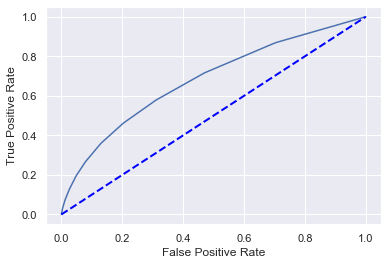

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [27]:
def ontime_departure(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
                'DAY_OF_MONTH': day,
                'DAY_OF_WEEK': day_of_week,
                'CRS_DEP_TIME': hour,
                'ORIGIN_ABE': 1 if origin =='ABE' else 0,
                'ORIGIN_ABI': 1 if origin =='ABI' else 0,
                'ORIGIN_ABQ': 1 if origin =='ABQ' else 0,
                'ORIGIN_ABR': 1 if origin =='ABR' else 0,
                'ORIGIN_ABY': 1 if origin =='ABY' else 0,
                'ORIGIN_ACT': 1 if origin =='ACT' else 0,
                'ORIGIN_ACV': 1 if origin =='ACV' else 0,
                'ORIGIN_ACY': 1 if origin =='ACY' else 0,
                'ORIGIN_ADK': 1 if origin =='ADK' else 0,
                'ORIGIN_ADQ': 1 if origin =='ADQ' else 0,
                'ORIGIN_AEX': 1 if origin =='AEX' else 0,
                'ORIGIN_AGS': 1 if origin =='AGS' else 0,
                'ORIGIN_ALB': 1 if origin =='ALB' else 0,
                'ORIGIN_ALO': 1 if origin =='ALO' else 0,
                'ORIGIN_AMA': 1 if origin =='AMA' else 0,
                'ORIGIN_ANC': 1 if origin =='ANC' else 0,
                'ORIGIN_APN': 1 if origin =='APN' else 0,
                'ORIGIN_ART': 1 if origin =='ART' else 0,
                'ORIGIN_ASE': 1 if origin =='ASE' else 0,
                'ORIGIN_ATL': 1 if origin =='ATL' else 0,
                'ORIGIN_ATW': 1 if origin =='ATW' else 0,
                'ORIGIN_AUS': 1 if origin =='AUS' else 0,
                'ORIGIN_AVL': 1 if origin =='AVL' else 0,
                'ORIGIN_AVP': 1 if origin =='AVP' else 0,
                'ORIGIN_AZA': 1 if origin =='AZA' else 0,
                'ORIGIN_AZO': 1 if origin =='AZO' else 0,
                'ORIGIN_BDL': 1 if origin =='BDL' else 0,
                'ORIGIN_BET': 1 if origin =='BET' else 0,
                'ORIGIN_BFF': 1 if origin =='BFF' else 0,
                'ORIGIN_BFL': 1 if origin =='BFL' else 0,
                'ORIGIN_BGM': 1 if origin =='BGM' else 0,
                'ORIGIN_BGR': 1 if origin =='BGR' else 0,
                'ORIGIN_BHM': 1 if origin =='BHM' else 0,
                'ORIGIN_BIL': 1 if origin =='BIL' else 0,
                'ORIGIN_BIS': 1 if origin =='BIS' else 0,
                'ORIGIN_BJI': 1 if origin =='BJI' else 0,
                'ORIGIN_BLI': 1 if origin =='BLI' else 0,
                'ORIGIN_BLV': 1 if origin =='BLV' else 0,
                'ORIGIN_BMI': 1 if origin =='BMI' else 0,
                'ORIGIN_BNA': 1 if origin =='BNA' else 0,
                'ORIGIN_BOI': 1 if origin =='BOI' else 0,
                'ORIGIN_BOS': 1 if origin =='BOS' else 0,
                'ORIGIN_BPT': 1 if origin =='BPT' else 0,
                'ORIGIN_BQK': 1 if origin =='BQK' else 0,
                'ORIGIN_BQN': 1 if origin =='BQN' else 0,
                'ORIGIN_BRD': 1 if origin =='BRD' else 0,
                'ORIGIN_BRO': 1 if origin =='BRO' else 0,
                'ORIGIN_BRW': 1 if origin =='BRW' else 0,
                'ORIGIN_BTM': 1 if origin =='BTM' else 0,
                'ORIGIN_BTR': 1 if origin =='BTR' else 0,
                'ORIGIN_BTV': 1 if origin =='BTV' else 0,
                'ORIGIN_BUF': 1 if origin =='BUF' else 0,
                'ORIGIN_BUR': 1 if origin =='BUR' else 0,
                'ORIGIN_BWI': 1 if origin =='BWI' else 0,
                'ORIGIN_BZN': 1 if origin =='BZN' else 0,
                'ORIGIN_CAE': 1 if origin =='CAE' else 0,
                'ORIGIN_CAK': 1 if origin =='CAK' else 0,
                'ORIGIN_CDC': 1 if origin =='CDC' else 0,
                'ORIGIN_CDV': 1 if origin =='CDV' else 0,
                'ORIGIN_CGI': 1 if origin =='CGI' else 0,
                'ORIGIN_CHA': 1 if origin =='CHA' else 0,
                'ORIGIN_CHO': 1 if origin =='CHO' else 0,
                'ORIGIN_CHS': 1 if origin =='CHS' else 0,
                'ORIGIN_CID': 1 if origin =='CID' else 0,
                'ORIGIN_CIU': 1 if origin =='CIU' else 0,
                'ORIGIN_CKB': 1 if origin =='CKB' else 0,
                'ORIGIN_CLE': 1 if origin =='CLE' else 0,
                'ORIGIN_CLL': 1 if origin =='CLL' else 0,
                'ORIGIN_CLT': 1 if origin =='CLT' else 0,
                'ORIGIN_CMH': 1 if origin =='CMH' else 0,
                'ORIGIN_CMI': 1 if origin =='CMI' else 0,
                'ORIGIN_CMX': 1 if origin =='CMX' else 0,
                'ORIGIN_CNY': 1 if origin =='CNY' else 0,
                'ORIGIN_COD': 1 if origin =='COD' else 0,
                'ORIGIN_COS': 1 if origin =='COS' else 0,
                'ORIGIN_COU': 1 if origin =='COU' else 0,
                'ORIGIN_CPR': 1 if origin =='CPR' else 0,
                'ORIGIN_CRP': 1 if origin =='CRP' else 0,
                'ORIGIN_CRW': 1 if origin =='CRW' else 0,
                'ORIGIN_CSG': 1 if origin =='CSG' else 0,
                'ORIGIN_CVG': 1 if origin =='CVG' else 0,
                'ORIGIN_CWA': 1 if origin =='CWA' else 0,
                'ORIGIN_CYS': 1 if origin =='CYS' else 0,
                'ORIGIN_DAB': 1 if origin =='DAB' else 0,
                'ORIGIN_DAL': 1 if origin =='DAL' else 0,
                'ORIGIN_DAY': 1 if origin =='DAY' else 0,
                'ORIGIN_DBQ': 1 if origin =='DBQ' else 0,
                'ORIGIN_DCA': 1 if origin =='DCA' else 0,
                'ORIGIN_DEN': 1 if origin =='DEN' else 0,
                'ORIGIN_DFW': 1 if origin =='DFW' else 0,
                'ORIGIN_DHN': 1 if origin =='DHN' else 0,
                'ORIGIN_DLH': 1 if origin =='DLH' else 0,
                'ORIGIN_DRO': 1 if origin =='DRO' else 0,
                'ORIGIN_DRT': 1 if origin =='DRT' else 0,
                'ORIGIN_DSM': 1 if origin =='DSM' else 0,
                'ORIGIN_DTW': 1 if origin =='DTW' else 0,
                'ORIGIN_DVL': 1 if origin =='DVL' else 0,
                'ORIGIN_EAR': 1 if origin =='EAR' else 0,
                'ORIGIN_EAU': 1 if origin =='EAU' else 0,
                'ORIGIN_ECP': 1 if origin =='ECP' else 0,
                'ORIGIN_EGE': 1 if origin =='EGE' else 0,
                'ORIGIN_EKO': 1 if origin =='EKO' else 0,
                'ORIGIN_ELM': 1 if origin =='ELM' else 0,
                'ORIGIN_ELP': 1 if origin =='ELP' else 0,
                'ORIGIN_ERI': 1 if origin =='ERI' else 0,
                'ORIGIN_ESC': 1 if origin =='ESC' else 0,
                'ORIGIN_EUG': 1 if origin =='EUG' else 0,
                'ORIGIN_EVV': 1 if origin =='EVV' else 0,
                'ORIGIN_EWN': 1 if origin =='EWN' else 0,
                'ORIGIN_EWR': 1 if origin =='EWR' else 0,
                'ORIGIN_EYW': 1 if origin =='EYW' else 0,
                'ORIGIN_FAI': 1 if origin =='FAI' else 0,
                'ORIGIN_FAR': 1 if origin =='FAR' else 0,
                'ORIGIN_FAT': 1 if origin =='FAT' else 0,
                'ORIGIN_FAY': 1 if origin =='FAY' else 0,
                'ORIGIN_FCA': 1 if origin =='FCA' else 0,
                'ORIGIN_FLG': 1 if origin =='FLG' else 0,
                'ORIGIN_FLL': 1 if origin =='FLL' else 0,
                'ORIGIN_FNT': 1 if origin =='FNT' else 0,
                'ORIGIN_FSD': 1 if origin =='FSD' else 0,
                'ORIGIN_FSM': 1 if origin =='FSM' else 0,
                'ORIGIN_FWA': 1 if origin =='FWA' else 0,
                'ORIGIN_GCC': 1 if origin =='GCC' else 0,
                'ORIGIN_GCK': 1 if origin =='GCK' else 0,
                'ORIGIN_GEG': 1 if origin =='GEG' else 0,
                'ORIGIN_GFK': 1 if origin =='GFK' else 0,
                'ORIGIN_GGG': 1 if origin =='GGG' else 0,
                'ORIGIN_GJT': 1 if origin =='GJT' else 0,
                'ORIGIN_GNV': 1 if origin =='GNV' else 0,
                'ORIGIN_GPT': 1 if origin =='GPT' else 0,
                'ORIGIN_GRB': 1 if origin =='GRB' else 0,
                'ORIGIN_GRI': 1 if origin =='GRI' else 0,
                'ORIGIN_GRK': 1 if origin =='GRK' else 0,
                'ORIGIN_GRR': 1 if origin =='GRR' else 0,
                'ORIGIN_GSO': 1 if origin =='GSO' else 0,
                'ORIGIN_GSP': 1 if origin =='GSP' else 0,
                'ORIGIN_GTF': 1 if origin =='GTF' else 0,
                'ORIGIN_GTR': 1 if origin =='GTR' else 0,
                'ORIGIN_GUC': 1 if origin =='GUC' else 0,
                'ORIGIN_GUM': 1 if origin =='GUM' else 0,
                'ORIGIN_HDN': 1 if origin =='HDN' else 0,
                'ORIGIN_HGR': 1 if origin =='HGR' else 0,
                'ORIGIN_HHH': 1 if origin =='HHH' else 0,
                'ORIGIN_HIB': 1 if origin =='HIB' else 0,
                'ORIGIN_HLN': 1 if origin =='HLN' else 0,
                'ORIGIN_HNL': 1 if origin =='HNL' else 0,
                'ORIGIN_HOB': 1 if origin =='HOB' else 0,
                'ORIGIN_HOU': 1 if origin =='HOU' else 0,
                'ORIGIN_HPN': 1 if origin =='HPN' else 0,
                'ORIGIN_HRL': 1 if origin =='HRL' else 0,
                'ORIGIN_HSV': 1 if origin =='HSV' else 0,
                'ORIGIN_HTS': 1 if origin =='HTS' else 0,
                'ORIGIN_HVN': 1 if origin =='HVN' else 0,
                'ORIGIN_HYS': 1 if origin =='HYS' else 0,
                'ORIGIN_IAD': 1 if origin =='IAD' else 0,
                'ORIGIN_IAG': 1 if origin =='IAG' else 0,
                'ORIGIN_IAH': 1 if origin =='IAH' else 0,
                'ORIGIN_ICT': 1 if origin =='ICT' else 0,
                'ORIGIN_IDA': 1 if origin =='IDA' else 0,
                'ORIGIN_ILM': 1 if origin =='ILM' else 0,
                'ORIGIN_IMT': 1 if origin =='IMT' else 0,
                'ORIGIN_IND': 1 if origin =='IND' else 0,
                'ORIGIN_INL': 1 if origin =='INL' else 0,
                'ORIGIN_ISN': 1 if origin =='ISN' else 0,
                'ORIGIN_ISP': 1 if origin =='ISP' else 0,
                'ORIGIN_ITH': 1 if origin =='ITH' else 0,
                'ORIGIN_ITO': 1 if origin =='ITO' else 0,
                'ORIGIN_JAC': 1 if origin =='JAC' else 0,
                'ORIGIN_JAN': 1 if origin =='JAN' else 0,
                'ORIGIN_JAX': 1 if origin =='JAX' else 0,
                'ORIGIN_JFK': 1 if origin =='JFK' else 0,
                'ORIGIN_JLN': 1 if origin =='JLN' else 0,
                'ORIGIN_JMS': 1 if origin =='JMS' else 0,
                'ORIGIN_JNU': 1 if origin =='JNU' else 0,
                'ORIGIN_KOA': 1 if origin =='KOA' else 0,
                'ORIGIN_KTN': 1 if origin =='KTN' else 0,
                'ORIGIN_LAN': 1 if origin =='LAN' else 0,
                'ORIGIN_LAR': 1 if origin =='LAR' else 0,
                'ORIGIN_LAS': 1 if origin =='LAS' else 0,
                'ORIGIN_LAW': 1 if origin =='LAW' else 0,
                'ORIGIN_LAX': 1 if origin =='LAX' else 0,
                'ORIGIN_LBB': 1 if origin =='LBB' else 0,
                'ORIGIN_LBE': 1 if origin =='LBE' else 0,
                'ORIGIN_LBF': 1 if origin =='LBF' else 0,
                'ORIGIN_LBL': 1 if origin =='LBL' else 0,
                'ORIGIN_LCH': 1 if origin =='LCH' else 0,
                'ORIGIN_LCK': 1 if origin =='LCK' else 0,
                'ORIGIN_LEX': 1 if origin =='LEX' else 0,
                'ORIGIN_LFT': 1 if origin =='LFT' else 0,
                'ORIGIN_LGA': 1 if origin =='LGA' else 0,
                'ORIGIN_LGB': 1 if origin =='LGB' else 0,
                'ORIGIN_LIH': 1 if origin =='LIH' else 0,
                'ORIGIN_LIT': 1 if origin =='LIT' else 0,
                'ORIGIN_LNK': 1 if origin =='LNK' else 0,
                'ORIGIN_LRD': 1 if origin =='LRD' else 0,
                'ORIGIN_LSE': 1 if origin =='LSE' else 0,
                'ORIGIN_LWB': 1 if origin =='LWB' else 0,
                'ORIGIN_LWS': 1 if origin =='LWS' else 0,
                'ORIGIN_LYH': 1 if origin =='LYH' else 0,
                'ORIGIN_MAF': 1 if origin =='MAF' else 0,
                'ORIGIN_MBS': 1 if origin =='MBS' else 0,
                'ORIGIN_MCI': 1 if origin =='MCI' else 0,
                'ORIGIN_MCO': 1 if origin =='MCO' else 0,
                'ORIGIN_MDT': 1 if origin =='MDT' else 0,
                'ORIGIN_MDW': 1 if origin =='MDW' else 0,
                'ORIGIN_MEI': 1 if origin =='MEI' else 0,
                'ORIGIN_MEM': 1 if origin =='MEM' else 0,
                'ORIGIN_MFE': 1 if origin =='MFE' else 0,
                'ORIGIN_MFR': 1 if origin =='MFR' else 0,
                'ORIGIN_MGM': 1 if origin =='MGM' else 0,
                'ORIGIN_MHK': 1 if origin =='MHK' else 0,
                'ORIGIN_MHT': 1 if origin =='MHT' else 0,
                'ORIGIN_MIA': 1 if origin =='MIA' else 0,
                'ORIGIN_MKE': 1 if origin =='MKE' else 0,
                'ORIGIN_MKG': 1 if origin =='MKG' else 0,
                'ORIGIN_MLB': 1 if origin =='MLB' else 0,
                'ORIGIN_MLI': 1 if origin =='MLI' else 0,
                'ORIGIN_MLU': 1 if origin =='MLU' else 0,
                'ORIGIN_MMH': 1 if origin =='MMH' else 0,
                'ORIGIN_MOB': 1 if origin =='MOB' else 0,
                'ORIGIN_MOT': 1 if origin =='MOT' else 0,
                'ORIGIN_MQT': 1 if origin =='MQT' else 0,
                'ORIGIN_MRY': 1 if origin =='MRY' else 0,
                'ORIGIN_MSN': 1 if origin =='MSN' else 0,
                'ORIGIN_MSO': 1 if origin =='MSO' else 0,
                'ORIGIN_MSP': 1 if origin =='MSP' else 0,
                'ORIGIN_MSY': 1 if origin =='MSY' else 0,
                'ORIGIN_MTJ': 1 if origin =='MTJ' else 0,
                'ORIGIN_MYR': 1 if origin =='MYR' else 0,
                'ORIGIN_OAJ': 1 if origin =='OAJ' else 0,
                'ORIGIN_OAK': 1 if origin =='OAK' else 0,
                'ORIGIN_OGD': 1 if origin =='OGD' else 0,
                'ORIGIN_OGG': 1 if origin =='OGG' else 0,
                'ORIGIN_OGS': 1 if origin =='OGS' else 0,
                'ORIGIN_OKC': 1 if origin =='OKC' else 0,
                'ORIGIN_OMA': 1 if origin =='OMA' else 0,
                'ORIGIN_OME': 1 if origin =='OME' else 0,
                'ORIGIN_ONT': 1 if origin =='ONT' else 0,
                'ORIGIN_ORD': 1 if origin =='ORD' else 0,
                'ORIGIN_ORF': 1 if origin =='ORF' else 0,
                'ORIGIN_ORH': 1 if origin =='ORH' else 0,
                'ORIGIN_OTH': 1 if origin =='OTH' else 0,
                'ORIGIN_OTZ': 1 if origin =='OTZ' else 0,
                'ORIGIN_OWB': 1 if origin =='OWB' else 0,
                'ORIGIN_PAH': 1 if origin =='PAH' else 0,
                'ORIGIN_PBG': 1 if origin =='PBG' else 0,
                'ORIGIN_PBI': 1 if origin =='PBI' else 0,
                'ORIGIN_PDX': 1 if origin =='PDX' else 0,
                'ORIGIN_PGD': 1 if origin =='PGD' else 0,
                'ORIGIN_PHF': 1 if origin =='PHF' else 0,
                'ORIGIN_PHL': 1 if origin =='PHL' else 0,
                'ORIGIN_PHX': 1 if origin =='PHX' else 0,
                'ORIGIN_PIA': 1 if origin =='PIA' else 0,
                'ORIGIN_PIB': 1 if origin =='PIB' else 0,
                'ORIGIN_PIE': 1 if origin =='PIE' else 0,
                'ORIGIN_PIH': 1 if origin =='PIH' else 0,
                'ORIGIN_PIT': 1 if origin =='PIT' else 0,
                'ORIGIN_PLN': 1 if origin =='PLN' else 0,
                'ORIGIN_PNS': 1 if origin =='PNS' else 0,
                'ORIGIN_PPG': 1 if origin =='PPG' else 0,
                'ORIGIN_PRC': 1 if origin =='PRC' else 0,
                'ORIGIN_PSC': 1 if origin =='PSC' else 0,
                'ORIGIN_PSE': 1 if origin =='PSE' else 0,
                'ORIGIN_PSG': 1 if origin =='PSG' else 0,
                'ORIGIN_PSM': 1 if origin =='PSM' else 0,
                'ORIGIN_PSP': 1 if origin =='PSP' else 0,
                'ORIGIN_PUB': 1 if origin =='PUB' else 0,
                'ORIGIN_PVD': 1 if origin =='PVD' else 0,
                'ORIGIN_PVU': 1 if origin =='PVU' else 0,
                'ORIGIN_PWM': 1 if origin =='PWM' else 0,
                'ORIGIN_RAP': 1 if origin =='RAP' else 0,
                'ORIGIN_RDD': 1 if origin =='RDD' else 0,
                'ORIGIN_RDM': 1 if origin =='RDM' else 0,
                'ORIGIN_RDU': 1 if origin =='RDU' else 0,
                'ORIGIN_RFD': 1 if origin =='RFD' else 0,
                'ORIGIN_RHI': 1 if origin =='RHI' else 0,
                'ORIGIN_RIC': 1 if origin =='RIC' else 0,
                'ORIGIN_RKS': 1 if origin =='RKS' else 0,
                'ORIGIN_RNO': 1 if origin =='RNO' else 0,
                'ORIGIN_ROA': 1 if origin =='ROA' else 0,
                'ORIGIN_ROC': 1 if origin =='ROC' else 0,
                'ORIGIN_ROW': 1 if origin =='ROW' else 0,
                'ORIGIN_RST': 1 if origin =='RST' else 0,
                'ORIGIN_RSW': 1 if origin =='RSW' else 0,
                'ORIGIN_SAF': 1 if origin =='SAF' else 0,
                'ORIGIN_SAN': 1 if origin =='SAN' else 0,
                'ORIGIN_SAT': 1 if origin =='SAT' else 0,
                'ORIGIN_SAV': 1 if origin =='SAV' else 0,
                'ORIGIN_SBA': 1 if origin =='SBA' else 0,
                'ORIGIN_SBN': 1 if origin =='SBN' else 0,
                'ORIGIN_SBP': 1 if origin =='SBP' else 0,
                'ORIGIN_SCC': 1 if origin =='SCC' else 0,
                'ORIGIN_SCE': 1 if origin =='SCE' else 0,
                'ORIGIN_SCK': 1 if origin =='SCK' else 0,
                'ORIGIN_SDF': 1 if origin =='SDF' else 0,
                'ORIGIN_SEA': 1 if origin =='SEA' else 0,
                'ORIGIN_SFB': 1 if origin =='SFB' else 0,
                'ORIGIN_SFO': 1 if origin =='SFO' else 0,
                'ORIGIN_SGF': 1 if origin =='SGF' else 0,
                'ORIGIN_SGU': 1 if origin =='SGU' else 0,
                'ORIGIN_SHD': 1 if origin =='SHD' else 0,
                'ORIGIN_SHV': 1 if origin =='SHV' else 0,
                'ORIGIN_SIT': 1 if origin =='SIT' else 0,
                'ORIGIN_SJC': 1 if origin =='SJC' else 0,
                'ORIGIN_SJT': 1 if origin =='SJT' else 0,
                'ORIGIN_SJU': 1 if origin =='SJU' else 0,
                'ORIGIN_SLC': 1 if origin =='SLC' else 0,
                'ORIGIN_SLN': 1 if origin =='SLN' else 0,
                'ORIGIN_SMF': 1 if origin =='SMF' else 0,
                'ORIGIN_SMX': 1 if origin =='SMX' else 0,
                'ORIGIN_SNA': 1 if origin =='SNA' else 0,
                'ORIGIN_SPI': 1 if origin =='SPI' else 0,
                'ORIGIN_SPN': 1 if origin =='SPN' else 0,
                'ORIGIN_SPS': 1 if origin =='SPS' else 0,
                'ORIGIN_SRQ': 1 if origin =='SRQ' else 0,
                'ORIGIN_STC': 1 if origin =='STC' else 0,
                'ORIGIN_STL': 1 if origin =='STL' else 0,
                'ORIGIN_STS': 1 if origin =='STS' else 0,
                'ORIGIN_STT': 1 if origin =='STT' else 0,
                'ORIGIN_STX': 1 if origin =='STX' else 0,
                'ORIGIN_SUN': 1 if origin =='SUN' else 0,
                'ORIGIN_SUX': 1 if origin =='SUX' else 0,
                'ORIGIN_SWF': 1 if origin =='SWF' else 0,
                'ORIGIN_SWO': 1 if origin =='SWO' else 0,
                'ORIGIN_SYR': 1 if origin =='SYR' else 0,
                'ORIGIN_TLH': 1 if origin =='TLH' else 0,
                'ORIGIN_TOL': 1 if origin =='TOL' else 0,
                'ORIGIN_TPA': 1 if origin =='TPA' else 0,
                'ORIGIN_TRI': 1 if origin =='TRI' else 0,
                'ORIGIN_TTN': 1 if origin =='TTN' else 0,
                'ORIGIN_TUL': 1 if origin =='TUL' else 0,
                'ORIGIN_TUS': 1 if origin =='TUS' else 0,
                'ORIGIN_TVC': 1 if origin =='TVC' else 0,
                'ORIGIN_TWF': 1 if origin =='TWF' else 0,
                'ORIGIN_TXK': 1 if origin =='TXK' else 0,
                'ORIGIN_TYR': 1 if origin =='TYR' else 0,
                'ORIGIN_TYS': 1 if origin =='TYS' else 0,
                'ORIGIN_UIN': 1 if origin =='UIN' else 0,
                'ORIGIN_USA': 1 if origin =='USA' else 0,
                'ORIGIN_VEL': 1 if origin =='VEL' else 0,
                'ORIGIN_VLD': 1 if origin =='VLD' else 0,
                'ORIGIN_VPS': 1 if origin =='VPS' else 0,
                'ORIGIN_WRG': 1 if origin =='WRG' else 0,
                'ORIGIN_XNA': 1 if origin =='XNA' else 0,
                'ORIGIN_YAK': 1 if origin =='YAK' else 0,
                'ORIGIN_YUM': 1 if origin =='YUM' else 0,
                'DEST_ABE': 1 if destination =='ABE' else 0,
                'DEST_ABI': 1 if destination =='ABI' else 0,
                'DEST_ABQ': 1 if destination =='ABQ' else 0,
                'DEST_ABR': 1 if destination =='ABR' else 0,
                'DEST_ABY': 1 if destination =='ABY' else 0,
                'DEST_ACT': 1 if destination =='ACT' else 0,
                'DEST_ACV': 1 if destination =='ACV' else 0,
                'DEST_ACY': 1 if destination =='ACY' else 0,
                'DEST_ADK': 1 if destination =='ADK' else 0,
                'DEST_ADQ': 1 if destination =='ADQ' else 0,
                'DEST_AEX': 1 if destination =='AEX' else 0,
                'DEST_AGS': 1 if destination =='AGS' else 0,
                'DEST_ALB': 1 if destination =='ALB' else 0,
                'DEST_ALO': 1 if destination =='ALO' else 0,
                'DEST_AMA': 1 if destination =='AMA' else 0,
                'DEST_ANC': 1 if destination =='ANC' else 0,
                'DEST_APN': 1 if destination =='APN' else 0,
                'DEST_ART': 1 if destination =='ART' else 0,
                'DEST_ASE': 1 if destination =='ASE' else 0,
                'DEST_ATL': 1 if destination =='ATL' else 0,
                'DEST_ATW': 1 if destination =='ATW' else 0,
                'DEST_AUS': 1 if destination =='AUS' else 0,
                'DEST_AVL': 1 if destination =='AVL' else 0,
                'DEST_AVP': 1 if destination =='AVP' else 0,
                'DEST_AZA': 1 if destination =='AZA' else 0,
                'DEST_AZO': 1 if destination =='AZO' else 0,
                'DEST_BDL': 1 if destination =='BDL' else 0,
                'DEST_BET': 1 if destination =='BET' else 0,
                'DEST_BFF': 1 if destination =='BFF' else 0,
                'DEST_BFL': 1 if destination =='BFL' else 0,
                'DEST_BGM': 1 if destination =='BGM' else 0,
                'DEST_BGR': 1 if destination =='BGR' else 0,
                'DEST_BHM': 1 if destination =='BHM' else 0,
                'DEST_BIL': 1 if destination =='BIL' else 0,
                'DEST_BIS': 1 if destination =='BIS' else 0,
                'DEST_BJI': 1 if destination =='BJI' else 0,
                'DEST_BLI': 1 if destination =='BLI' else 0,
                'DEST_BLV': 1 if destination =='BLV' else 0,
                'DEST_BMI': 1 if destination =='BMI' else 0,
                'DEST_BNA': 1 if destination =='BNA' else 0,
                'DEST_BOI': 1 if destination =='BOI' else 0,
                'DEST_BOS': 1 if destination =='BOS' else 0,
                'DEST_BPT': 1 if destination =='BPT' else 0,
                'DEST_BQK': 1 if destination =='BQK' else 0,
                'DEST_BQN': 1 if destination =='BQN' else 0,
                'DEST_BRD': 1 if destination =='BRD' else 0,
                'DEST_BRO': 1 if destination =='BRO' else 0,
                'DEST_BRW': 1 if destination =='BRW' else 0,
                'DEST_BTM': 1 if destination =='BTM' else 0,
                'DEST_BTR': 1 if destination =='BTR' else 0,
                'DEST_BTV': 1 if destination =='BTV' else 0,
                'DEST_BUF': 1 if destination =='BUF' else 0,
                'DEST_BUR': 1 if destination =='BUR' else 0,
                'DEST_BWI': 1 if destination =='BWI' else 0,
                'DEST_BZN': 1 if destination =='BZN' else 0,
                'DEST_CAE': 1 if destination =='CAE' else 0,
                'DEST_CAK': 1 if destination =='CAK' else 0,
                'DEST_CDC': 1 if destination =='CDC' else 0,
                'DEST_CDV': 1 if destination =='CDV' else 0,
                'DEST_CGI': 1 if destination =='CGI' else 0,
                'DEST_CHA': 1 if destination =='CHA' else 0,
                'DEST_CHO': 1 if destination =='CHO' else 0,
                'DEST_CHS': 1 if destination =='CHS' else 0,
                'DEST_CID': 1 if destination =='CID' else 0,
                'DEST_CIU': 1 if destination =='CIU' else 0,
                'DEST_CKB': 1 if destination =='CKB' else 0,
                'DEST_CLE': 1 if destination =='CLE' else 0,
                'DEST_CLL': 1 if destination =='CLL' else 0,
                'DEST_CLT': 1 if destination =='CLT' else 0,
                'DEST_CMH': 1 if destination =='CMH' else 0,
                'DEST_CMI': 1 if destination =='CMI' else 0,
                'DEST_CMX': 1 if destination =='CMX' else 0,
                'DEST_CNY': 1 if destination =='CNY' else 0,
                'DEST_COD': 1 if destination =='COD' else 0,
                'DEST_COS': 1 if destination =='COS' else 0,
                'DEST_COU': 1 if destination =='COU' else 0,
                'DEST_CPR': 1 if destination =='CPR' else 0,
                'DEST_CRP': 1 if destination =='CRP' else 0,
                'DEST_CRW': 1 if destination =='CRW' else 0,
                'DEST_CSG': 1 if destination =='CSG' else 0,
                'DEST_CVG': 1 if destination =='CVG' else 0,
                'DEST_CWA': 1 if destination =='CWA' else 0,
                'DEST_CYS': 1 if destination =='CYS' else 0,
                'DEST_DAB': 1 if destination =='DAB' else 0,
                'DEST_DAL': 1 if destination =='DAL' else 0,
                'DEST_DAY': 1 if destination =='DAY' else 0,
                'DEST_DBQ': 1 if destination =='DBQ' else 0,
                'DEST_DCA': 1 if destination =='DCA' else 0,
                'DEST_DEN': 1 if destination =='DEN' else 0,
                'DEST_DFW': 1 if destination =='DFW' else 0,
                'DEST_DHN': 1 if destination =='DHN' else 0,
                'DEST_DLH': 1 if destination =='DLH' else 0,
                'DEST_DRO': 1 if destination =='DRO' else 0,
                'DEST_DRT': 1 if destination =='DRT' else 0,
                'DEST_DSM': 1 if destination =='DSM' else 0,
                'DEST_DTW': 1 if destination =='DTW' else 0,
                'DEST_DVL': 1 if destination =='DVL' else 0,
                'DEST_EAR': 1 if destination =='EAR' else 0,
                'DEST_EAU': 1 if destination =='EAU' else 0,
                'DEST_ECP': 1 if destination =='ECP' else 0,
                'DEST_EGE': 1 if destination =='EGE' else 0,
                'DEST_EKO': 1 if destination =='EKO' else 0,
                'DEST_ELM': 1 if destination =='ELM' else 0,
                'DEST_ELP': 1 if destination =='ELP' else 0,
                'DEST_ERI': 1 if destination =='ERI' else 0,
                'DEST_ESC': 1 if destination =='ESC' else 0,
                'DEST_EUG': 1 if destination =='EUG' else 0,
                'DEST_EVV': 1 if destination =='EVV' else 0,
                'DEST_EWN': 1 if destination =='EWN' else 0,
                'DEST_EWR': 1 if destination =='EWR' else 0,
                'DEST_EYW': 1 if destination =='EYW' else 0,
                'DEST_FAI': 1 if destination =='FAI' else 0,
                'DEST_FAR': 1 if destination =='FAR' else 0,
                'DEST_FAT': 1 if destination =='FAT' else 0,
                'DEST_FAY': 1 if destination =='FAY' else 0,
                'DEST_FCA': 1 if destination =='FCA' else 0,
                'DEST_FLG': 1 if destination =='FLG' else 0,
                'DEST_FLL': 1 if destination =='FLL' else 0,
                'DEST_FNT': 1 if destination =='FNT' else 0,
                'DEST_FSD': 1 if destination =='FSD' else 0,
                'DEST_FSM': 1 if destination =='FSM' else 0,
                'DEST_FWA': 1 if destination =='FWA' else 0,
                'DEST_GCC': 1 if destination =='GCC' else 0,
                'DEST_GCK': 1 if destination =='GCK' else 0,
                'DEST_GEG': 1 if destination =='GEG' else 0,
                'DEST_GFK': 1 if destination =='GFK' else 0,
                'DEST_GGG': 1 if destination =='GGG' else 0,
                'DEST_GJT': 1 if destination =='GJT' else 0,
                'DEST_GNV': 1 if destination =='GNV' else 0,
                'DEST_GPT': 1 if destination =='GPT' else 0,
                'DEST_GRB': 1 if destination =='GRB' else 0,
                'DEST_GRI': 1 if destination =='GRI' else 0,
                'DEST_GRK': 1 if destination =='GRK' else 0,
                'DEST_GRR': 1 if destination =='GRR' else 0,
                'DEST_GSO': 1 if destination =='GSO' else 0,
                'DEST_GSP': 1 if destination =='GSP' else 0,
                'DEST_GTF': 1 if destination =='GTF' else 0,
                'DEST_GTR': 1 if destination =='GTR' else 0,
                'DEST_GUC': 1 if destination =='GUC' else 0,
                'DEST_GUM': 1 if destination =='GUM' else 0,
                'DEST_HDN': 1 if destination =='HDN' else 0,
                'DEST_HGR': 1 if destination =='HGR' else 0,
                'DEST_HHH': 1 if destination =='HHH' else 0,
                'DEST_HIB': 1 if destination =='HIB' else 0,
                'DEST_HLN': 1 if destination =='HLN' else 0,
                'DEST_HNL': 1 if destination =='HNL' else 0,
                'DEST_HOB': 1 if destination =='HOB' else 0,
                'DEST_HOU': 1 if destination =='HOU' else 0,
                'DEST_HPN': 1 if destination =='HPN' else 0,
                'DEST_HRL': 1 if destination =='HRL' else 0,
                'DEST_HSV': 1 if destination =='HSV' else 0,
                'DEST_HTS': 1 if destination =='HTS' else 0,
                'DEST_HVN': 1 if destination =='HVN' else 0,
                'DEST_HYS': 1 if destination =='HYS' else 0,
                'DEST_IAD': 1 if destination =='IAD' else 0,
                'DEST_IAG': 1 if destination =='IAG' else 0,
                'DEST_IAH': 1 if destination =='IAH' else 0,
                'DEST_ICT': 1 if destination =='ICT' else 0,
                'DEST_IDA': 1 if destination =='IDA' else 0,
                'DEST_ILM': 1 if destination =='ILM' else 0,
                'DEST_IMT': 1 if destination =='IMT' else 0,
                'DEST_IND': 1 if destination =='IND' else 0,
                'DEST_INL': 1 if destination =='INL' else 0,
                'DEST_ISN': 1 if destination =='ISN' else 0,
                'DEST_ISP': 1 if destination =='ISP' else 0,
                'DEST_ITH': 1 if destination =='ITH' else 0,
                'DEST_ITO': 1 if destination =='ITO' else 0,
                'DEST_JAC': 1 if destination =='JAC' else 0,
                'DEST_JAN': 1 if destination =='JAN' else 0,
                'DEST_JAX': 1 if destination =='JAX' else 0,
                'DEST_JFK': 1 if destination =='JFK' else 0,
                'DEST_JLN': 1 if destination =='JLN' else 0,
                'DEST_JMS': 1 if destination =='JMS' else 0,
                'DEST_JNU': 1 if destination =='JNU' else 0,
                'DEST_KOA': 1 if destination =='KOA' else 0,
                'DEST_KTN': 1 if destination =='KTN' else 0,
                'DEST_LAN': 1 if destination =='LAN' else 0,
                'DEST_LAR': 1 if destination =='LAR' else 0,
                'DEST_LAS': 1 if destination =='LAS' else 0,
                'DEST_LAW': 1 if destination =='LAW' else 0,
                'DEST_LAX': 1 if destination =='LAX' else 0,
                'DEST_LBB': 1 if destination =='LBB' else 0,
                'DEST_LBE': 1 if destination =='LBE' else 0,
                'DEST_LBF': 1 if destination =='LBF' else 0,
                'DEST_LBL': 1 if destination =='LBL' else 0,
                'DEST_LCH': 1 if destination =='LCH' else 0,
                'DEST_LCK': 1 if destination =='LCK' else 0,
                'DEST_LEX': 1 if destination =='LEX' else 0,
                'DEST_LFT': 1 if destination =='LFT' else 0,
                'DEST_LGA': 1 if destination =='LGA' else 0,
                'DEST_LGB': 1 if destination =='LGB' else 0,
                'DEST_LIH': 1 if destination =='LIH' else 0,
                'DEST_LIT': 1 if destination =='LIT' else 0,
                'DEST_LNK': 1 if destination =='LNK' else 0,
                'DEST_LRD': 1 if destination =='LRD' else 0,
                'DEST_LSE': 1 if destination =='LSE' else 0,
                'DEST_LWB': 1 if destination =='LWB' else 0,
                'DEST_LWS': 1 if destination =='LWS' else 0,
                'DEST_LYH': 1 if destination =='LYH' else 0,
                'DEST_MAF': 1 if destination =='MAF' else 0,
                'DEST_MBS': 1 if destination =='MBS' else 0,
                'DEST_MCI': 1 if destination =='MCI' else 0,
                'DEST_MCO': 1 if destination =='MCO' else 0,
                'DEST_MDT': 1 if destination =='MDT' else 0,
                'DEST_MDW': 1 if destination =='MDW' else 0,
                'DEST_MEI': 1 if destination =='MEI' else 0,
                'DEST_MEM': 1 if destination =='MEM' else 0,
                'DEST_MFE': 1 if destination =='MFE' else 0,
                'DEST_MFR': 1 if destination =='MFR' else 0,
                'DEST_MGM': 1 if destination =='MGM' else 0,
                'DEST_MHK': 1 if destination =='MHK' else 0,
                'DEST_MHT': 1 if destination =='MHT' else 0,
                'DEST_MIA': 1 if destination =='MIA' else 0,
                'DEST_MKE': 1 if destination =='MKE' else 0,
                'DEST_MKG': 1 if destination =='MKG' else 0,
                'DEST_MLB': 1 if destination =='MLB' else 0,
                'DEST_MLI': 1 if destination =='MLI' else 0,
                'DEST_MLU': 1 if destination =='MLU' else 0,
                'DEST_MMH': 1 if destination =='MMH' else 0,
                'DEST_MOB': 1 if destination =='MOB' else 0,
                'DEST_MOT': 1 if destination =='MOT' else 0,
                'DEST_MQT': 1 if destination =='MQT' else 0,
                'DEST_MRY': 1 if destination =='MRY' else 0,
                'DEST_MSN': 1 if destination =='MSN' else 0,
                'DEST_MSO': 1 if destination =='MSO' else 0,
                'DEST_MSP': 1 if destination =='MSP' else 0,
                'DEST_MSY': 1 if destination =='MSY' else 0,
                'DEST_MTJ': 1 if destination =='MTJ' else 0,
                'DEST_MYR': 1 if destination =='MYR' else 0,
                'DEST_OAJ': 1 if destination =='OAJ' else 0,
                'DEST_OAK': 1 if destination =='OAK' else 0,
                'DEST_OGD': 1 if destination =='OGD' else 0,
                'DEST_OGG': 1 if destination =='OGG' else 0,
                'DEST_OGS': 1 if destination =='OGS' else 0,
                'DEST_OKC': 1 if destination =='OKC' else 0,
                'DEST_OMA': 1 if destination =='OMA' else 0,
                'DEST_OME': 1 if destination =='OME' else 0,
                'DEST_ONT': 1 if destination =='ONT' else 0,
                'DEST_ORD': 1 if destination =='ORD' else 0,
                'DEST_ORF': 1 if destination =='ORF' else 0,
                'DEST_ORH': 1 if destination =='ORH' else 0,
                'DEST_OTH': 1 if destination =='OTH' else 0,
                'DEST_OTZ': 1 if destination =='OTZ' else 0,
                'DEST_OWB': 1 if destination =='OWB' else 0,
                'DEST_PAH': 1 if destination =='PAH' else 0,
                'DEST_PBG': 1 if destination =='PBG' else 0,
                'DEST_PBI': 1 if destination =='PBI' else 0,
                'DEST_PDX': 1 if destination =='PDX' else 0,
                'DEST_PGD': 1 if destination =='PGD' else 0,
                'DEST_PHF': 1 if destination =='PHF' else 0,
                'DEST_PHL': 1 if destination =='PHL' else 0,
                'DEST_PHX': 1 if destination =='PHX' else 0,
                'DEST_PIA': 1 if destination =='PIA' else 0,
                'DEST_PIB': 1 if destination =='PIB' else 0,
                'DEST_PIE': 1 if destination =='PIE' else 0,
                'DEST_PIH': 1 if destination =='PIH' else 0,
                'DEST_PIT': 1 if destination =='PIT' else 0,
                'DEST_PLN': 1 if destination =='PLN' else 0,
                'DEST_PNS': 1 if destination =='PNS' else 0,
                'DEST_PPG': 1 if destination =='PPG' else 0,
                'DEST_PRC': 1 if destination =='PRC' else 0,
                'DEST_PSC': 1 if destination =='PSC' else 0,
                'DEST_PSE': 1 if destination =='PSE' else 0,
                'DEST_PSG': 1 if destination =='PSG' else 0,
                'DEST_PSM': 1 if destination =='PSM' else 0,
                'DEST_PSP': 1 if destination =='PSP' else 0,
                'DEST_PUB': 1 if destination =='PUB' else 0,
                'DEST_PVD': 1 if destination =='PVD' else 0,
                'DEST_PVU': 1 if destination =='PVU' else 0,
                'DEST_PWM': 1 if destination =='PWM' else 0,
                'DEST_RAP': 1 if destination =='RAP' else 0,
                'DEST_RDD': 1 if destination =='RDD' else 0,
                'DEST_RDM': 1 if destination =='RDM' else 0,
                'DEST_RDU': 1 if destination =='RDU' else 0,
                'DEST_RFD': 1 if destination =='RFD' else 0,
                'DEST_RHI': 1 if destination =='RHI' else 0,
                'DEST_RIC': 1 if destination =='RIC' else 0,
                'DEST_RKS': 1 if destination =='RKS' else 0,
                'DEST_RNO': 1 if destination =='RNO' else 0,
                'DEST_ROA': 1 if destination =='ROA' else 0,
                'DEST_ROC': 1 if destination =='ROC' else 0,
                'DEST_ROW': 1 if destination =='ROW' else 0,
                'DEST_RST': 1 if destination =='RST' else 0,
                'DEST_RSW': 1 if destination =='RSW' else 0,
                'DEST_SAF': 1 if destination =='SAF' else 0,
                'DEST_SAN': 1 if destination =='SAN' else 0,
                'DEST_SAT': 1 if destination =='SAT' else 0,
                'DEST_SAV': 1 if destination =='SAV' else 0,
                'DEST_SBA': 1 if destination =='SBA' else 0,
                'DEST_SBN': 1 if destination =='SBN' else 0,
                'DEST_SBP': 1 if destination =='SBP' else 0,
                'DEST_SCC': 1 if destination =='SCC' else 0,
                'DEST_SCE': 1 if destination =='SCE' else 0,
                'DEST_SCK': 1 if destination =='SCK' else 0,
                'DEST_SDF': 1 if destination =='SDF' else 0,
                'DEST_SEA': 1 if destination =='SEA' else 0,
                'DEST_SFB': 1 if destination =='SFB' else 0,
                'DEST_SFO': 1 if destination =='SFO' else 0,
                'DEST_SGF': 1 if destination =='SGF' else 0,
                'DEST_SGU': 1 if destination =='SGU' else 0,
                'DEST_SHD': 1 if destination =='SHD' else 0,
                'DEST_SHV': 1 if destination =='SHV' else 0,
                'DEST_SIT': 1 if destination =='SIT' else 0,
                'DEST_SJC': 1 if destination =='SJC' else 0,
                'DEST_SJT': 1 if destination =='SJT' else 0,
                'DEST_SJU': 1 if destination =='SJU' else 0,
                'DEST_SLC': 1 if destination =='SLC' else 0,
                'DEST_SLN': 1 if destination =='SLN' else 0,
                'DEST_SMF': 1 if destination =='SMF' else 0,
                'DEST_SMX': 1 if destination =='SMX' else 0,
                'DEST_SNA': 1 if destination =='SNA' else 0,
                'DEST_SPI': 1 if destination =='SPI' else 0,
                'DEST_SPN': 1 if destination =='SPN' else 0,
                'DEST_SPS': 1 if destination =='SPS' else 0,
                'DEST_SRQ': 1 if destination =='SRQ' else 0,
                'DEST_STC': 1 if destination =='STC' else 0,
                'DEST_STL': 1 if destination =='STL' else 0,
                'DEST_STS': 1 if destination =='STS' else 0,
                'DEST_STT': 1 if destination =='STT' else 0,
                'DEST_STX': 1 if destination =='STX' else 0,
                'DEST_SUN': 1 if destination =='SUN' else 0,
                'DEST_SUX': 1 if destination =='SUX' else 0,
                'DEST_SWF': 1 if destination =='SWF' else 0,
                'DEST_SWO': 1 if destination =='SWO' else 0,
                'DEST_SYR': 1 if destination =='SYR' else 0,
                'DEST_TLH': 1 if destination =='TLH' else 0,
                'DEST_TOL': 1 if destination =='TOL' else 0,
                'DEST_TPA': 1 if destination =='TPA' else 0,
                'DEST_TRI': 1 if destination =='TRI' else 0,
                'DEST_TTN': 1 if destination =='TTN' else 0,
                'DEST_TUL': 1 if destination =='TUL' else 0,
                'DEST_TUS': 1 if destination =='TUS' else 0,
                'DEST_TVC': 1 if destination =='TVC' else 0,
                'DEST_TWF': 1 if destination =='TWF' else 0,
                'DEST_TXK': 1 if destination =='TXK' else 0,
                'DEST_TYR': 1 if destination =='TYR' else 0,
                'DEST_TYS': 1 if destination =='TYS' else 0,
                'DEST_UIN': 1 if destination =='UIN' else 0,
                'DEST_USA': 1 if destination =='USA' else 0,
                'DEST_VEL': 1 if destination =='VEL' else 0,
                'DEST_VLD': 1 if destination =='VLD' else 0,
                'DEST_VPS': 1 if destination =='VPS' else 0,
                'DEST_WRG': 1 if destination =='WRG' else 0,
                'DEST_XNA': 1 if destination =='XNA' else 0,
                'DEST_YAK': 1 if destination =='YAK' else 0,
                'DEST_YUM': 1 if destination =='YUM' else 0}]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [28]:
ontime_departure('17/1/2020 21:00:00', 'SFO', 'IAD')

0.9

In [38]:
ontime_departure('18/12/2020 09:30:00', 'LAX', 'SFO')

0.8

(0.0, 1.0)

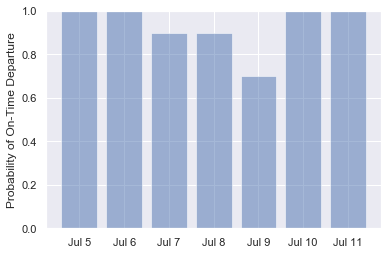

In [39]:
import numpy as np

labels = ('Jul 5', 'Jul 6', 'Jul 7', 'Jul 8', 'Jul 9', 'Jul 10', 'Jul 11')
values = (ontime_departure('5/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('6/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('7/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('8/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('9/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('10/07/2020 21:45:00', 'SFO', 'LAX'),
          ontime_departure('11/07/2020 21:45:00', 'SFO', 'LAX'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Departure')
plt.ylim((0.0, 1.0))